#### Setting Up

##### pip

In [ ]:
!pip install -q datasets
!pip install -q peft
!pip install -q evaluate
!pip install -q rouge_score

##### libraries

In [ ]:
import torch
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset
from rouge_score import rouge_scorer
from sklearn.model_selection import train_test_split
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq)

##### config

In [2]:
MODEL_NAME = "ai-forever/ruT5-base"
CACHE_DIR = 'data/finetune/model_cache'
OUTPUT_DIR = 'data/finetune/fine_tuned_model'
MODEL_DIR = "./trained_model"

#### Data

In [14]:
# load preprocessed dataset
data_full = pd.read_csv("/content/synthetic.csv")

In [16]:
# data size
data_full.shape

(14039, 4)

In [20]:
# stratified splitting to preserve balance
train_data, val_data = train_test_split(data_full,
                                        test_size=0.1,
                                        random_state=42,
                                        stratify=data_full[['category', 'sentiment']])

#### Model Prerequisites

In [ ]:
# load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)

##### or

In [7]:
# load the fine-tuned tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(OUTPUT_DIR)
model = AutoModelForSeq2SeqLM.from_pretrained(OUTPUT_DIR)

# ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
# preprocessing function
def preprocess_function(examples):
    """
    Preprocesses the input examples by tokenizing the 'clean_text' and 'synthetic' fields.

    Args:
        examples (dict): A dictionary containing the input examples with keys 'clean_text' and 'synthetic'.

    Returns:
        dict: A dictionary containing tokenized inputs and labels. The keys are:
            - 'input_ids': Tokenized input ids of 'clean_text'.
            - 'attention_mask': Attention mask for the input ids.
            - 'labels': Tokenized input ids of 'synthetic'.
    """
    # tokenize the inputs (clean_text)
    inputs = tokenizer(examples['clean_text'],
                       max_length=512,
                       padding='longest',
                       truncation=True)

    # tokenize the targets (synthetic)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['synthetic'],
                           max_length=128, 
                           padding='longest', 
                           truncation=True)

    inputs['labels'] = labels['input_ids']
    return inputs

In [4]:
# convert pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_data[['clean_text', 'synthetic']])
val_dataset = Dataset.from_pandas(val_data[['clean_text', 'synthetic']])

# apply the preprocessing
train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=['clean_text', 'synthetic'])
val_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=['clean_text', 'synthetic'])

# check dataset sizes
print(f"Обучающая выборка: {len(train_dataset)} записей")
print(f"Валидационная выборка: {len(val_dataset)} записей")

(14040, 4)

#### Traning

In [5]:
# define training arguments
training_args = TrainingArguments(output_dir=OUTPUT_DIR,
                                  overwrite_output_dir=True,
                                  num_train_epochs=3, # try 5
                                  per_device_train_batch_size=4, # or 8
                                  per_device_eval_batch_size=4, # or 8
                                  gradient_accumulation_steps=2,
                                  eval_strategy="epoch",
                                  save_strategy="epoch",
                                  save_total_limit=2,
                                  max_grad_norm=1.0,
                                  learning_rate=5e-5,
                                  lr_scheduler_type="linear", # or cosine
                                  warmup_ratio=0.1,
                                  weight_decay=0.01,
                                  fp16=True,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="loss", 
                                  greater_is_better=False,
                                  report_to="none")

# initialize the data collator for seq2seq
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# initialize the Trainer
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  data_collator=data_collator,
                  processing_class=tokenizer)

# start training
trainer.train()

In [ ]:
# save the fine-tuned model
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

#### Infrerence

In [8]:
# define the generation function
def generate_pros_cons(review, max_length=128, min_length=32, num_return_sequences=1, temperature=0.3, top_p=0.75, top_k=30):
    """
    Generates pros and cons from a given review using a pre-trained language model.

    Args:
        review (str): The review text to generate pros and cons from.
    """

    # tokenize the input
    inputs = tokenizer.encode(review, return_tensors="pt", truncation=True, max_length=512)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = inputs.to(device)

    # generate the output
    with torch.no_grad():
        outputs = model.generate(
            inputs,
            do_sample=True,
            max_length=max_length,
            min_length=min_length,
            num_return_sequences=num_return_sequences,
            no_repeat_ngram_size=2,
            top_p=top_p,
            temperature=temperature,
            top_k=top_k,
            early_stopping=True,
            pad_token_id=tokenizer.eos_token_id
        )

    # decode the generated tokens
    generated = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return generated

In [85]:
test_data = pd.read_csv('data/test.csv')

In [10]:
# select a sample review from the test data
sample = test_data['clean_text'].loc[12]
print(f"Review: {sample}")

# generate pros and cons for the selected review
pros_cons = generate_pros_cons(sample)
print(f"Pros and Cons: {pros_cons}")

Review: Уютное и приятное место в центре города. Проводили деловую встречу с желанием перекусить. К огромному сожалению ждали официантов целый час, в итоге ограничились напитками и ушли. При этом зал был почти пустым,официанты просто занимались непонятно чем. По случаю приобрела в кафе Пасхальный кулич - и это божественно вкусно. В общем итог- кафе, кофе и выпечка, только за это 4*, работа официантов 1* и та в минусе.
Pros and Cons: ['Сильные стороны: 1. Уютная и приятное место. 2. Вкусная еда (пасхальный кулич). Слабые стороны (долгое ожидание официантов). 2. Пустой зал. 3. Невнимательность персонала (официанты отвлекаются на непонятные занятия).']


In [38]:
# select a sample review from the test data
sample = test_data['clean_text'].loc[1]
print(f"Review: {sample}")

# generate pros and cons for the selected review
pros_cons = generate_pros_cons(sample)
print(f"Pros and Cons: {pros_cons}")

Review: Роллы с майонезом, то есть - рис залитый мазиком - не вкусно Бао так же залито мазиком - не вкусно Доставка по Пятигорску с ожиданием в 2 часа Вся ваша еда по вкусу как салат из дешевой столовки После этой «еды», один из нас отравился ел бао с курицей
Pros and Cons: ['Сильные стороны: не выявлены Слабые стороны (невкусные роллы с майонезом, рис залит мазиком) 2. Долгое ожидание доставки по Пятигорску 3. Качество еды (бао с курицей)']


In [40]:
# select a sample review from the test data
sample = test_data['clean_text'].loc[4]
print(f"Review: {sample}")

# generate pros and cons for the selected review
pros_cons = generate_pros_cons(sample)
print(f"Pros and Cons: {pros_cons}")

Review: Заказ был сделан в 17:00. 2 - 2,5 часа ожидание, как у всех. Итог - время 21:30 - так ничего и нет. При звонке в эту контору отвечает автоответчик, 2 минуты музыки и вызов завершен. Звонили раз 10 с разных номеров - ответ один - все операторы заняты. Не знаю, во сколько теперь приедет курьер, но заказ будет отменен. Над доставкой в этой конторе стоит поработать. Зато при оформлении заказа девушка так старалась "продать" дополнительно палочки!, имбирь, соусы и прочие вкусности, что имеются в меню. Задумайтесь, прежде чем заказывать в этом месте. Скупой платит дважды. Вечер можно считать испорченным.
Pros and Cons: ['Сильные стороны: не выявлены Слабые стороны (долгое ожидание заказа) 2. Некорректное общение с автоответчиком 3. Недостаток персонала 4. Несвоевременная доставка (заказ отменен) 5. Несоответствие времени доставки заявленному времени 6. Недовольство качеством доставки']


#### ROUGE

In [88]:
def compute_rouge_scores(test_data, index, scorer):
    """
    Computes ROUGE scores for a given sample from the test data.

    Args:
        test_data (pd.DataFrame): The test dataset containing 'clean_text' and 'synthetic' columns.
        index (int): The index of the sample to evaluate.
        scorer (rouge_scorer.RougeScorer): The ROUGE scorer object.
    Returns:
        dict: A dictionary containing the ROUGE scores.
    """
    sample = test_data['clean_text'].loc[index]
    reference = test_data['synthetic'].loc[index]
    predicted = ' '.join(generate_pros_cons(sample))

    scores = scorer.score(reference, predicted)
    return scores

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
index = 4
scores = compute_rouge_scores(test_data, index, scorer)

for key, value in scores.items():
    print(f"{key}: Precision: {value.precision:.2f}, Recall: {value.recall:.2f}, F1-Score: {value.fmeasure:.2f}")

rouge1: Precision: 1.00, Recall: 0.60, F1-Score: 0.75
rougeL: Precision: 1.00, Recall: 0.60, F1-Score: 0.75


In [89]:
all_scores = []

for i in tqdm(range(len(test_data))):
    scores = compute_rouge_scores(test_data, i, scorer)
    # Extract scores into a dictionary or row format
    row = {
        'index': i,
        'rouge1_precision': scores['rouge1'].precision,
        'rouge1_recall': scores['rouge1'].recall,
        'rouge1_f1': scores['rouge1'].fmeasure,
        'rougeL_precision': scores['rougeL'].precision,
        'rougeL_recall': scores['rougeL'].recall,
        'rougeL_f1': scores['rougeL'].fmeasure
    }
    all_scores.append(row)

scores_df = pd.DataFrame(all_scores)

100%|██████████| 47/47 [01:56<00:00,  2.48s/it]


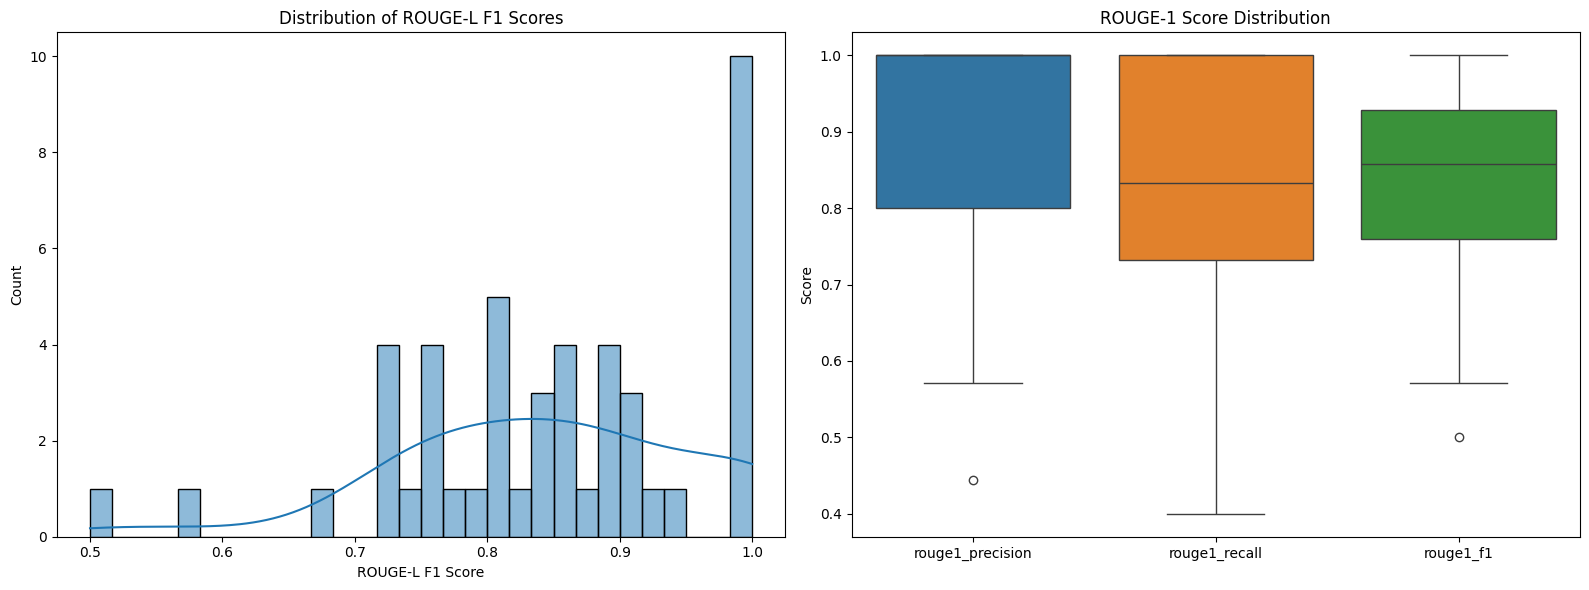

In [91]:
# visualize the Results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# plot the distribution of ROUGE-L F1 Scores
sns.histplot(data=scores_df, x='rougeL_f1', bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of ROUGE-L F1 Scores')
axes[0].set_xlabel('ROUGE-L F1 Score')
axes[0].set_ylabel('Count')

# plot the boxplot for ROUGE-1 Scores
sns.boxplot(data=scores_df[['rouge1_precision', 'rouge1_recall', 'rouge1_f1']], ax=axes[1])
axes[1].set_title('ROUGE-1 Score Distribution')
axes[1].set_ylabel('Score')

plt.tight_layout()
plt.show()